# Last homework: designing a microscope using machine learning

For the final homework assignment, we will design a microscope using machine learning! In order to do this, we will combine elements of HW3 (CNNs) and HW4 (microscope simulator) into a single end-to-end architecture. In particular, we will convert the MNIST digits into phase/amplitude objects and process them through a microscope simulator as we did in HW4, add noise, and then feed the output into a CNN to classify the digit. In addition to optimizing the CNN parameters, we will also be simultaneously optimizing the input illumination incident on the sample as well as the aperture plane.

Below, we will walk you through the steps of implementing this joint architecture, leaving some portions blank for you to implement. We will first instruct you to use specific values that we have tested and are known to give reasonable results. Later on, you will revisit the code and explore different hyperparameter settings.

## 1. import stuff and load MNIST
As always, we split the dataset into training and testing. This code was copied from the jupyter notebook from TA session 5 and slightly modified.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib notebook

# load MNIST dataset:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# verify that the shapes are correct:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# cast as a float32:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## 2. convert the MNIST images into microscope samples
Convert the MNIST images into phase-only objects. To do this, normalize the MNIST digits to be between 0 and 1, and make the object 1 wavelength thick (we may come back later to adjust the sample thickness).

In [2]:
wavelength = .5
def convert_MNIST(X):
    # your code here
    X = X/255.0
    X_phase = X
    optical_thickness = wavelength
    X = np.exp(1j * X *optical_thickness/wavelength) #complex exponential represents phase delay
    return X

X_train = convert_MNIST(X_train)
X_test = convert_MNIST(X_test)

## 3. create input pipeline for generating training/testing batches
For your convenience, this was also copied from TA session 5 (and slightly modified). You don't need to do anything here but run this block:

In [3]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.complex64, [None, 28, 28], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

## 4. create complex-valued trainable illumination
The input field will be a 28x28 complex-valued field that interacts with the sample. In practice, this input field might be obtained by using a spatial light modulator (SLM), an optical element that can be programmed to display an arbitrary phase and/or amplitude pattern pixel by pixel. We will use a phase-only SLM, so that the variable to optimize is a 28x28 array of phases (from 0 to 2pi).

In [4]:
# use this flag to allow/disallow training of the input illumination; tf.Variable has an argument called "trainable":
train_illumination = True  

# create the variable corresponding to the input illumination phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
input_illumination_phase = tf.get_variable("illum_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.constant_initializer(np.pi/6), trainable = train_illumination)

# using that input phase, create the input field:
input_illumination = tf.exp(1j*2*np.pi/wavelength*tf.to_complex64(input_illumination_phase))

## 5. generate the emerging field from the sample
Given a stack of input images, X_batch (generated above), create a tensorflow array representing the emerging field from the sample. This is the same as what you did in HW4, except in HW4 you had a tilted plane wave.

In [5]:
# be sure to match the shapes/dimensions to enable broadcasting:
emerging_field = tf.math.multiply(X_batch, input_illumination)

## 6. propagate the emerging field to the aperture plane
As in HW4, propagate the field emerging from the sample to the aperture plane (also known as the Fourier plane). Remember to use tensorflow operations!

In [6]:
def tf_fftshift2(A):
    # 2D fftshift
    # apply fftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2] + 1
    s2 = s[-1] + 1
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def tf_ifftshift2(A):
    # 2D ifftshift
    # apply ifftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2]
    s2 = s[-1]
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

In [7]:
aperture_plane = tf_fftshift2(tf.fft2d(tf_ifftshift2(emerging_field)))

## 7. create complex-valued trainable aperture function
In HW4, we modeled a circular aperture in the aperture plane of our microscope. Please do the same here. For now, in whatever coordinate system you have established, please try to ensure that the radius extends across 8 pixels of the 28 pixels that will define the k-space matrix for this MNIST dataset along one dimension. We may come back later to adjust this radius.

In addition, for extra flexibility, let's add an SLM in the aperture plane. Assume the SLM is a phase-only SLM (only values from 0 to 2pi are allowed).

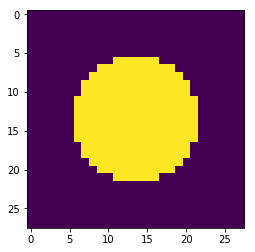

In [8]:
y_t, x_t = np.ogrid[0:28, 0:28]
initial = (x_t - 13.5)**2 + (y_t -13.5)**2 <= 8 * 8
initial = initial.reshape((28,28))
plt.figure()
plt.imshow(initial)

In [9]:
# use this flag to allow/disallow training of the aperture plane; pass this into the tf.Variable definition:
train_aperture = True

# the aperture function consists of two parts: 1) the circular aperture as in HW4, and 2) a trainable 28x28 phase array
# create a circular aperture as you did in HW4:
circ_aper = initial

# create the variable corresponding to the aperture phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
aperture_phase = tf.get_variable("aper_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.constant_initializer(0), trainable = train_aperture)

# write the full aperture function, combining the above two components:
aperture = tf.multiply(tf.to_complex64(circ_aper), tf.exp(1j*2*np.pi*tf.to_complex64(aperture_phase)))

# filter the field that you propagated:
aperture_plane_filtered = tf.multiply(aperture_plane, aperture)

## 8. propagate to the image plane
Next, we propagate the field to the image plane and take the magnitude squared (since we can only measure intensity). Add some Gaussian noise, since real measurements are noisy. Use tf.random_normal and for now use a stddev of .05. 

In [10]:
# propagate the field from the aperture plane to the image plane and convert it to intensity:
image = tf.abs(tf_ifftshift2(tf.ifft2d(tf_fftshift2(aperture_plane_filtered))))

# add noise:
image += tf.random_normal(shape=(28,28), stddev = 0.05)

## 9. process the simulated image through a CNN
Use your favorite CNN architecture that classifies MNIST or come up with a new one. You may copy a network architecture from a previous TA or class session.

In [11]:
def CNN2(net, numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net 

In [12]:
net_input_layer = image[..., None]  # add a channels dimension

# define your CNN here
logits = CNN2(net_input_layer)

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

prediction = tf.argmax(logits,1)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction, tf.to_int64(y_batch))))

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## 10. train!

In [13]:
# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

Let's first look at a few simulated noisy microscope images.

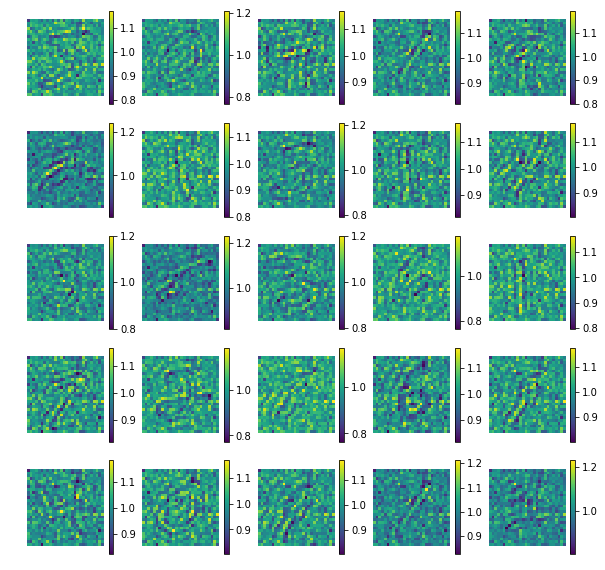

In [14]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i])
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(image.eval())

Write your train loop here. Feel free to monitor loss and/or aperture/illumination phases during training. When we tested this, the optimizer had a slow start, and we had to run for several 1000 batches. Pick a value for the number of iterations and keep it fixed.

In [15]:
# train loop:
for i in range(20001):
    _, tloss = sess.run([train_op, loss])
    if i%100==0:
        print("iteration %d; batch classifier loss: %f" % (i,tloss))

iteration 0; batch classifier loss: 3.484354
iteration 100; batch classifier loss: 2.262649
iteration 200; batch classifier loss: 1.534319
iteration 300; batch classifier loss: 0.643291
iteration 400; batch classifier loss: 0.453692
iteration 500; batch classifier loss: 0.683530
iteration 600; batch classifier loss: 0.434109
iteration 700; batch classifier loss: 0.260890
iteration 800; batch classifier loss: 0.232717
iteration 900; batch classifier loss: 0.290663
iteration 1000; batch classifier loss: 0.291181
iteration 1100; batch classifier loss: 0.528918
iteration 1200; batch classifier loss: 0.131511
iteration 1300; batch classifier loss: 0.092551
iteration 1400; batch classifier loss: 0.386534
iteration 1500; batch classifier loss: 0.139052
iteration 1600; batch classifier loss: 0.203203
iteration 1700; batch classifier loss: 0.254603
iteration 1800; batch classifier loss: 0.306195
iteration 1900; batch classifier loss: 0.442034
iteration 2000; batch classifier loss: 0.212195
iter

iteration 16900; batch classifier loss: 0.099078
iteration 17000; batch classifier loss: 0.017872
iteration 17100; batch classifier loss: 0.108816
iteration 17200; batch classifier loss: 0.012818
iteration 17300; batch classifier loss: 0.024067
iteration 17400; batch classifier loss: 0.030078
iteration 17500; batch classifier loss: 0.019127
iteration 17600; batch classifier loss: 0.009470
iteration 17700; batch classifier loss: 0.053284
iteration 17800; batch classifier loss: 0.009426
iteration 17900; batch classifier loss: 0.031736
iteration 18000; batch classifier loss: 0.071264
iteration 18100; batch classifier loss: 0.028832
iteration 18200; batch classifier loss: 0.171762
iteration 18300; batch classifier loss: 0.022232
iteration 18400; batch classifier loss: 0.019264
iteration 18500; batch classifier loss: 0.021945
iteration 18600; batch classifier loss: 0.012725
iteration 18700; batch classifier loss: 0.004255
iteration 18800; batch classifier loss: 0.011401
iteration 18900; bat

Let's first look at a few simulated noisy microscope images AFTER training. Do the images look more recognizable?

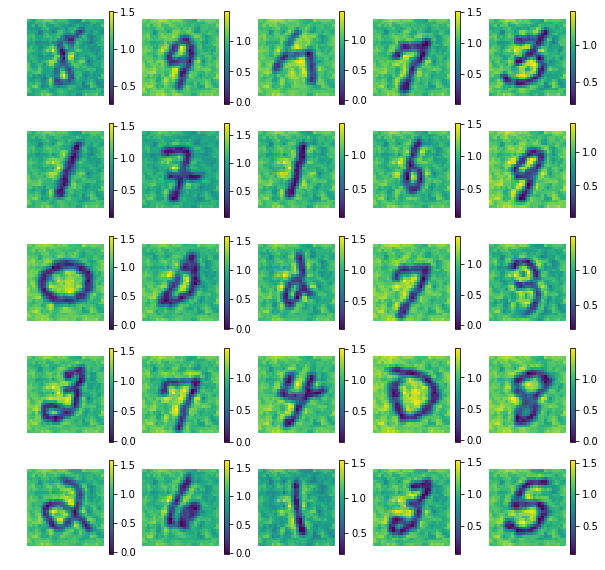

In [16]:
# plot examples 
plot_examples(image.eval())

Pass through the test set.

In [17]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test, y_train_or_test: y_test})
acc = []
# pass through test set:
for i in trange(len(X_test)//batch_size+1):
    batchacc = sess.run(accuracy)
    acc.append(batchacc)
print("accuracy:", np.mean(acc))

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 298.32it/s]


accuracy: 0.985024


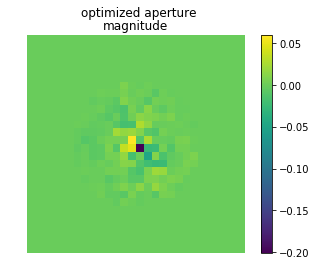

In [18]:
aper = sess.run(aperture_phase)
plt.figure()
plt.imshow(aper)
plt.title("magnitude")
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized aperture")
plt.show()

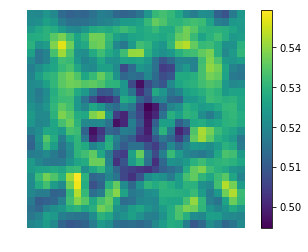

In [19]:
aper = sess.run(input_illumination_phase)
plt.figure()
plt.imshow(aper)
plt.colorbar()
plt.axis('off')
plt.show()

Ok, now you've run a machine learning model with a physical layer! You did it! Please respond to the following questions. Note that this is a pretty open-ended analysis, and everyone may achieve different results depending on the selected parameters -- as long as you get question 1 to work, it's okay if the other questions give uninteresting results!

1. First, using the default hyperparameters based on the instructions and code we provided, please run the training under the following conditions:
    1. Allowing optimization of aperture phase and illumination phase.
    2. Allowing optimization of neither aperture phase nor illumination phase (this is a control experiment, because only the CNN is trained).
    3. Allowing optimization of only the aperture phase.
    4. Allowing optimization of only the illumination phase.
    
    For these 4 conditions, report the final test classification accuracies as well as the optimized aperture phase and/or illumination phase. Provide a brief analysis of the results (hint: if you don't see a difference between at least two of the above conditions, something probably went wrong!).
   
2. If you got question 1 to work, good work! Next, let's try changing some of the hyperparameters above. For each of the following questions, rerun the analysis from question 1 (under conditions of 1A and 1B). Ideally, we want to find situations where the CNN with the physical layer (the microscope simulating layers) outperforms the CNN-only network. Comment on the gap in performance between the physically-optimized and non-physically-optimized cases. Also comment on the optimized aperture and/or illumination phase.

    * For question 1, you initialized with a constant phase. Next, try to initialize the optimization with random-valued aperture phase and illumination phase.
    * Try changing the diameter of the aperture to two other values. For example, half and double the original diameter used above.

### Part 1 Answer
Accuracies: 
A) 98.6%
B) 89.2%
C) 98.3%
D) 98.6%

As expected, optimising the aperture and the illumination does help a lot with the performance. We get a similar pattern everytime, indicating that results obtained are not coincidental. Even if optimize just one of the two things, we obtain an improvement in the accuracy. The effect of the optimization is that it makes the numbers much clearer to see. But interestingly, in the illumination only case, the digits actually become much worse to see visually, but still have a better performance in automated classification than the unoptimized case.

### Part 2 Answer

By changing the initilization to random, the output pattern was also not well-defined. Although the accuracy in optimized case of 95.6% is better than the 93.3% in unoptimized case, it is not the most significant improvement. Also, visually, the images after optimization cannot be distinguished from the ones without optimization.

After doubling the aperture diameter and optimizing the phases, we get an accuracy of 98.3%. But, in unoptimized case, it is not possible to classify the digits at all, and we obtain an accuracy of 11%. Optimized patterns are similar to the ones obtained before.

With half the aperture diameter, the accuracy without optimization is 95.2%. The numbers can be identified visually most of the time so it is not surprising. With optimization, the accuracy goes up a bit to 97.7%. The aperture pattern obtained is similar to the ones seen before. Illumination pattern is also somewhat like the one obtained before.

#### Part 1 A

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib notebook

# load MNIST dataset:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# verify that the shapes are correct:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# cast as a float32:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

wavelength = .5
def convert_MNIST(X):
    # your code here
    X = X/255.0
    X_phase = X
    optical_thickness = wavelength
    X = np.exp(1j * X *optical_thickness/wavelength) #complex exponential represents phase delay
    return X

def tf_fftshift2(A):
    # 2D fftshift
    # apply fftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2] + 1
    s2 = s[-1] + 1
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def tf_ifftshift2(A):
    # 2D ifftshift
    # apply ifftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2]
    s2 = s[-1]
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def CNN2(net, numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net 

X_train = convert_MNIST(X_train)
X_test = convert_MNIST(X_test)

# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.complex64, [None, 28, 28], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

# use this flag to allow/disallow training of the input illumination; tf.Variable has an argument called "trainable":
train_illumination = True  

# create the variable corresponding to the input illumination phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
input_illumination_phase = tf.get_variable("illum_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.constant_initializer(np.pi/6), trainable = train_illumination)

# using that input phase, create the input field:
input_illumination = tf.exp(1j*2*np.pi/wavelength*tf.to_complex64(input_illumination_phase))

# be sure to match the shapes/dimensions to enable broadcasting:
emerging_field = tf.math.multiply(X_batch, input_illumination)
aperture_plane = tf_fftshift2(tf.fft2d(tf_ifftshift2(emerging_field)))

y_t, x_t = np.ogrid[0:28, 0:28]
initial = (x_t - 13.5)**2 + (y_t -13.5)**2 <= 8 * 8
initial = initial.reshape((28,28))

# use this flag to allow/disallow training of the aperture plane; pass this into the tf.Variable definition:
train_aperture = True

# the aperture function consists of two parts: 1) the circular aperture as in HW4, and 2) a trainable 28x28 phase array
# create a circular aperture as you did in HW4:
circ_aper = initial

# create the variable corresponding to the aperture phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
aperture_phase = tf.get_variable("aper_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.constant_initializer(0), trainable = train_aperture)

# write the full aperture function, combining the above two components:
aperture = tf.multiply(tf.to_complex64(circ_aper), tf.exp(1j*2*np.pi*tf.to_complex64(aperture_phase)))

# filter the field that you propagated:
aperture_plane_filtered = tf.multiply(aperture_plane, aperture)

# propagate the field from the aperture plane to the image plane and convert it to intensity:
image = tf.abs(tf_ifftshift2(tf.ifft2d(tf_fftshift2(aperture_plane_filtered))))

# add noise:
image += tf.random_normal(shape=(28,28), stddev = 0.05)

net_input_layer = image[..., None]  # add a channels dimension

# define your CNN here
logits = CNN2(net_input_layer)

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

prediction = tf.argmax(logits,1)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction, tf.to_int64(y_batch))))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


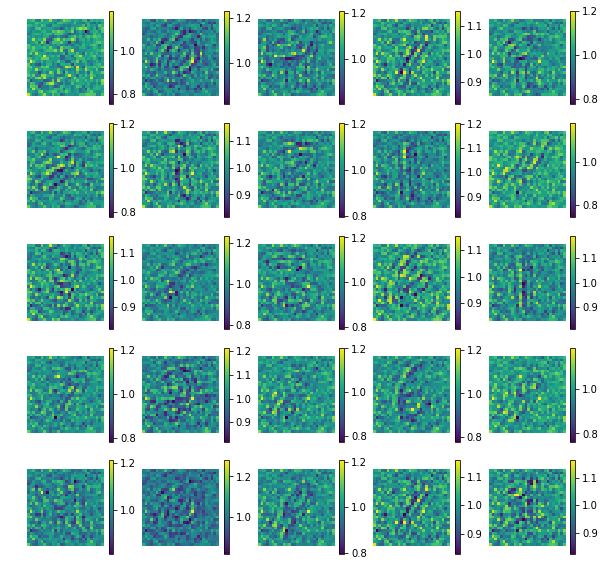

iteration 0; batch classifier loss: 2.887127
iteration 100; batch classifier loss: 2.244710
iteration 200; batch classifier loss: 1.446125
iteration 300; batch classifier loss: 0.545861
iteration 400; batch classifier loss: 0.457947
iteration 500; batch classifier loss: 0.731764
iteration 600; batch classifier loss: 0.429656
iteration 700; batch classifier loss: 0.236645
iteration 800; batch classifier loss: 0.192682
iteration 900; batch classifier loss: 0.281388
iteration 1000; batch classifier loss: 0.165267
iteration 1100; batch classifier loss: 0.400732
iteration 1200; batch classifier loss: 0.145759
iteration 1300; batch classifier loss: 0.097817
iteration 1400; batch classifier loss: 0.336573
iteration 1500; batch classifier loss: 0.095338
iteration 1600; batch classifier loss: 0.279612
iteration 1700; batch classifier loss: 0.152324
iteration 1800; batch classifier loss: 0.391631
iteration 1900; batch classifier loss: 0.485303
iteration 2000; batch classifier loss: 0.170663
iter

In [2]:
# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})
# train loop:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i])
        plt.colorbar()
        plt.axis('off')
    plt.show()
plot_examples(image.eval())

for i in range(20001):
    _, tloss = sess.run([train_op, loss])
    if i%100==0:
        print("iteration %d; batch classifier loss: %f" % (i,tloss))

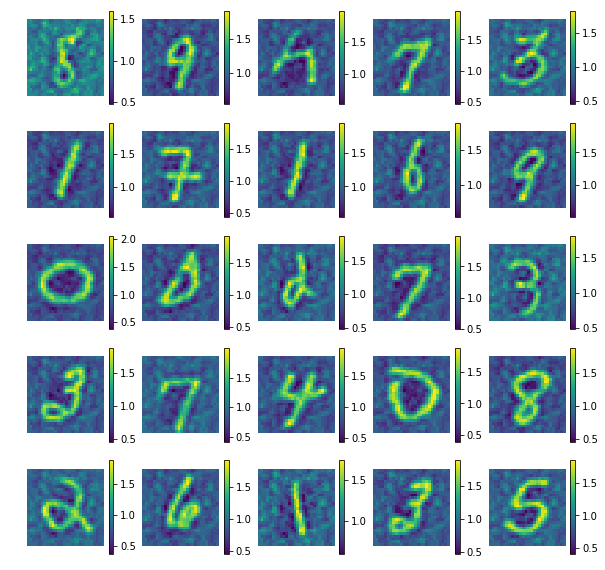

In [3]:
plot_examples(image.eval())

In [4]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test, y_train_or_test: y_test})
acc = []
# pass through test set:
for i in trange(len(X_test)//batch_size+1):
    batchacc = sess.run(accuracy)
    acc.append(batchacc)
print("accuracy:", np.mean(acc))

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 271.01it/s]


accuracy: 0.9859225


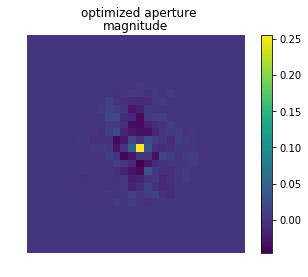

In [5]:
aper = sess.run(aperture_phase)
plt.figure()
plt.imshow(aper)
plt.title("magnitude")
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized aperture")
plt.show()

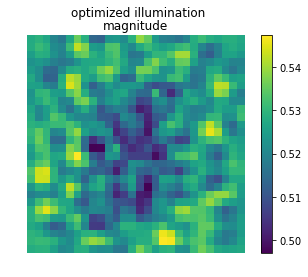

In [7]:
aper = sess.run(input_illumination_phase)
plt.figure()
plt.imshow(aper)
plt.title("magnitude")
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized illumination")
plt.show()

#### Part 1 B

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib notebook

# load MNIST dataset:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# verify that the shapes are correct:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# cast as a float32:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

wavelength = .5
def convert_MNIST(X):
    # your code here
    X = X/255.0
    X_phase = X
    optical_thickness = wavelength
    X = np.exp(1j * X *optical_thickness/wavelength) #complex exponential represents phase delay
    return X

def tf_fftshift2(A):
    # 2D fftshift
    # apply fftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2] + 1
    s2 = s[-1] + 1
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def tf_ifftshift2(A):
    # 2D ifftshift
    # apply ifftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2]
    s2 = s[-1]
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def CNN2(net, numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net 

X_train = convert_MNIST(X_train)
X_test = convert_MNIST(X_test)

# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.complex64, [None, 28, 28], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

# use this flag to allow/disallow training of the input illumination; tf.Variable has an argument called "trainable":
train_illumination = False  

# create the variable corresponding to the input illumination phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
input_illumination_phase = tf.get_variable("illum_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.constant_initializer(np.pi/6), trainable = train_illumination)

# using that input phase, create the input field:
input_illumination = tf.exp(1j*2*np.pi/wavelength*tf.to_complex64(input_illumination_phase))

# be sure to match the shapes/dimensions to enable broadcasting:
emerging_field = tf.math.multiply(X_batch, input_illumination)
aperture_plane = tf_fftshift2(tf.fft2d(tf_ifftshift2(emerging_field)))

y_t, x_t = np.ogrid[0:28, 0:28]
initial = (x_t - 13.5)**2 + (y_t -13.5)**2 <= 8 * 8
initial = initial.reshape((28,28))

# use this flag to allow/disallow training of the aperture plane; pass this into the tf.Variable definition:
train_aperture = False

# the aperture function consists of two parts: 1) the circular aperture as in HW4, and 2) a trainable 28x28 phase array
# create a circular aperture as you did in HW4:
circ_aper = initial

# create the variable corresponding to the aperture phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
aperture_phase = tf.get_variable("aper_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.constant_initializer(0), trainable = train_aperture)

# write the full aperture function, combining the above two components:
aperture = tf.multiply(tf.to_complex64(circ_aper), tf.exp(1j*2*np.pi*tf.to_complex64(aperture_phase)))

# filter the field that you propagated:
aperture_plane_filtered = tf.multiply(aperture_plane, aperture)

# propagate the field from the aperture plane to the image plane and convert it to intensity:
image = tf.abs(tf_ifftshift2(tf.ifft2d(tf_fftshift2(aperture_plane_filtered))))

# add noise:
image += tf.random_normal(shape=(28,28), stddev = 0.05)

net_input_layer = image[..., None]  # add a channels dimension

# define your CNN here
logits = CNN2(net_input_layer)

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

prediction = tf.argmax(logits,1)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction, tf.to_int64(y_batch))))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


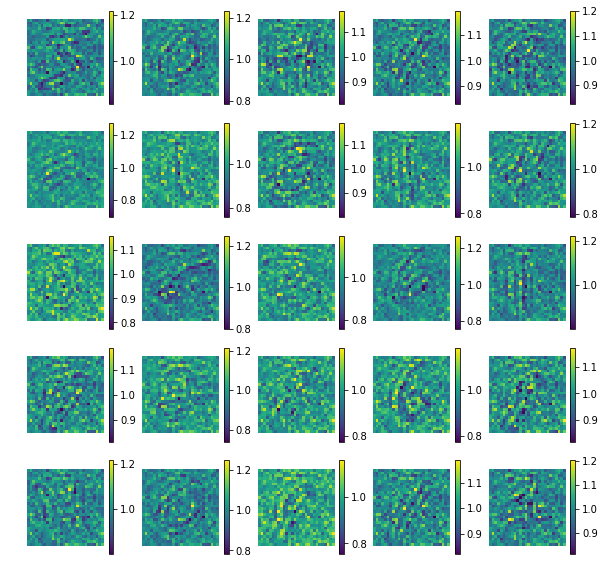

iteration 0; batch classifier loss: 4.158412
iteration 100; batch classifier loss: 2.281556
iteration 200; batch classifier loss: 2.413929
iteration 300; batch classifier loss: 2.297768
iteration 400; batch classifier loss: 2.312979
iteration 500; batch classifier loss: 2.299545
iteration 600; batch classifier loss: 2.285340
iteration 700; batch classifier loss: 2.306273
iteration 800; batch classifier loss: 2.331758
iteration 900; batch classifier loss: 2.362908
iteration 1000; batch classifier loss: 2.281693
iteration 1100; batch classifier loss: 2.473947
iteration 1200; batch classifier loss: 2.299438
iteration 1300; batch classifier loss: 2.234269
iteration 1400; batch classifier loss: 2.287727
iteration 1500; batch classifier loss: 2.275512
iteration 1600; batch classifier loss: 2.350370
iteration 1700; batch classifier loss: 2.340408
iteration 1800; batch classifier loss: 2.219951
iteration 1900; batch classifier loss: 2.379769
iteration 2000; batch classifier loss: 2.212565
iter

In [2]:
# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})
# train loop:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i])
        plt.colorbar()
        plt.axis('off')
    plt.show()
plot_examples(image.eval())

for i in range(20001):
    _, tloss = sess.run([train_op, loss])
    if i%100==0:
        print("iteration %d; batch classifier loss: %f" % (i,tloss))

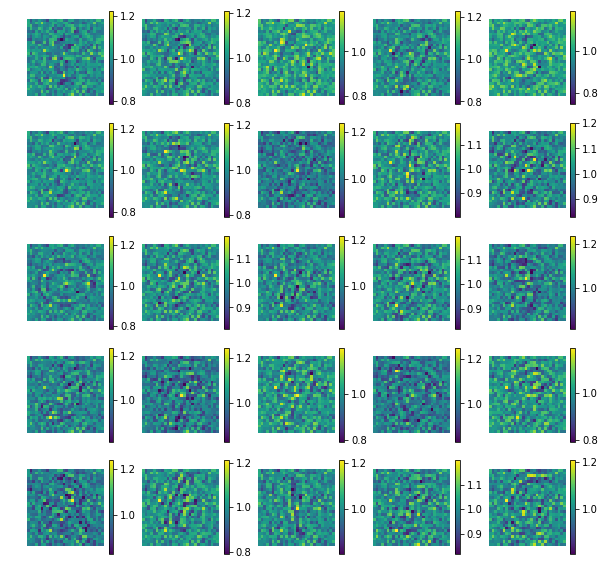

In [3]:
plot_examples(image.eval())

In [4]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test, y_train_or_test: y_test})
acc = []
# pass through test set:
for i in trange(len(X_test)//batch_size+1):
    batchacc = sess.run(accuracy)
    acc.append(batchacc)
print("accuracy:", np.mean(acc))

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 302.63it/s]


accuracy: 0.892472


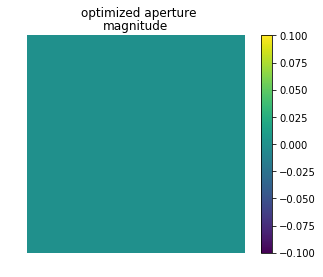

In [8]:
aper = sess.run(aperture_phase)
plt.figure()
plt.imshow(aper)
plt.title("magnitude")
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized aperture")
plt.show()

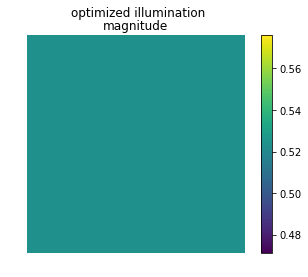

In [7]:
aper = sess.run(input_illumination_phase)
plt.figure()
plt.imshow(aper)
plt.title("magnitude")
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized illumination")
plt.show()

#### Part 1C

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib notebook

# load MNIST dataset:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# verify that the shapes are correct:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# cast as a float32:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

wavelength = .5
def convert_MNIST(X):
    # your code here
    X = X/255.0
    X_phase = X
    optical_thickness = wavelength
    X = np.exp(1j * X *optical_thickness/wavelength) #complex exponential represents phase delay
    return X

def tf_fftshift2(A):
    # 2D fftshift
    # apply fftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2] + 1
    s2 = s[-1] + 1
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def tf_ifftshift2(A):
    # 2D ifftshift
    # apply ifftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2]
    s2 = s[-1]
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def CNN2(net, numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net 

X_train = convert_MNIST(X_train)
X_test = convert_MNIST(X_test)

# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.complex64, [None, 28, 28], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

# use this flag to allow/disallow training of the input illumination; tf.Variable has an argument called "trainable":
train_illumination = True

# create the variable corresponding to the input illumination phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
input_illumination_phase = tf.get_variable("illum_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.constant_initializer(0), trainable = train_illumination)

# using that input phase, create the input field:
input_illumination = tf.exp(1j*2*np.pi/wavelength*tf.to_complex64(input_illumination_phase))

# be sure to match the shapes/dimensions to enable broadcasting:
emerging_field = tf.math.multiply(X_batch, input_illumination)
aperture_plane = tf_fftshift2(tf.fft2d(tf_ifftshift2(emerging_field)))

y_t, x_t = np.ogrid[0:28, 0:28]
initial = (x_t - 13.5)**2 + (y_t -13.5)**2 <= 8 * 8
initial = initial.reshape((28,28))

# use this flag to allow/disallow training of the aperture plane; pass this into the tf.Variable definition:
train_aperture = False

# the aperture function consists of two parts: 1) the circular aperture as in HW4, and 2) a trainable 28x28 phase array
# create a circular aperture as you did in HW4:
circ_aper = initial

# create the variable corresponding to the aperture phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
aperture_phase = tf.get_variable("aper_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.constant_initializer(0), trainable = train_aperture)

# write the full aperture function, combining the above two components:
aperture = tf.multiply(tf.to_complex64(circ_aper), tf.exp(1j*2*np.pi*tf.to_complex64(aperture_phase)))

# filter the field that you propagated:
aperture_plane_filtered = tf.multiply(aperture_plane, aperture)

# propagate the field from the aperture plane to the image plane and convert it to intensity:
image = tf.abs(tf_ifftshift2(tf.ifft2d(tf_fftshift2(aperture_plane_filtered))))

# add noise:
image += tf.random_normal(shape=(28,28), stddev = 0.05)

net_input_layer = image[..., None]  # add a channels dimension

# define your CNN here
logits = CNN2(net_input_layer)

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

prediction = tf.argmax(logits,1)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction, tf.to_int64(y_batch))))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


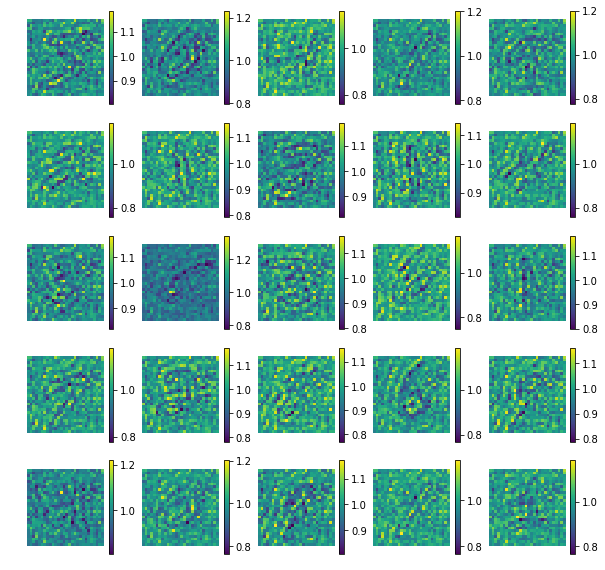

iteration 0; batch classifier loss: 2.894128
iteration 100; batch classifier loss: 2.279469
iteration 200; batch classifier loss: 2.437009
iteration 300; batch classifier loss: 2.268023
iteration 400; batch classifier loss: 2.325729
iteration 500; batch classifier loss: 2.315620
iteration 600; batch classifier loss: 2.268326
iteration 700; batch classifier loss: 2.309964
iteration 800; batch classifier loss: 2.300612
iteration 900; batch classifier loss: 2.295961
iteration 1000; batch classifier loss: 2.166352
iteration 1100; batch classifier loss: 2.515768
iteration 1200; batch classifier loss: 1.655752
iteration 1300; batch classifier loss: 0.940268
iteration 1400; batch classifier loss: 0.973096
iteration 1500; batch classifier loss: 0.581770
iteration 1600; batch classifier loss: 0.954478
iteration 1700; batch classifier loss: 0.404438
iteration 1800; batch classifier loss: 0.668203
iteration 1900; batch classifier loss: 0.782068
iteration 2000; batch classifier loss: 0.548320
iter

In [2]:
# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})
# train loop:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i])
        plt.colorbar()
        plt.axis('off')
    plt.show()
plot_examples(image.eval())

for i in range(20001):
    _, tloss = sess.run([train_op, loss])
    if i%100==0:
        print("iteration %d; batch classifier loss: %f" % (i,tloss))

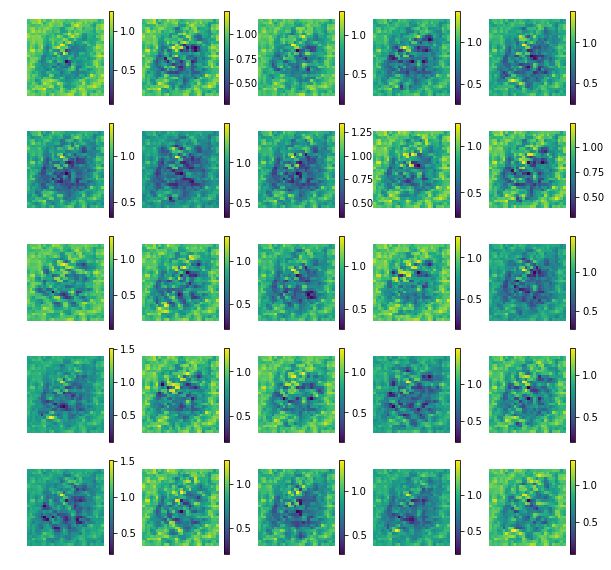

In [3]:
plot_examples(image.eval())

In [4]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test, y_train_or_test: y_test})
acc = []
# pass through test set:
for i in trange(len(X_test)//batch_size+1):
    batchacc = sess.run(accuracy)
    acc.append(batchacc)
print("accuracy:", np.mean(acc))

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 278.97it/s]


accuracy: 0.9685503


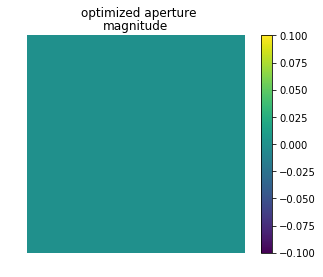

In [5]:
aper = sess.run(aperture_phase)
plt.figure()
plt.imshow(aper)
plt.title("magnitude")
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized aperture")
plt.show()

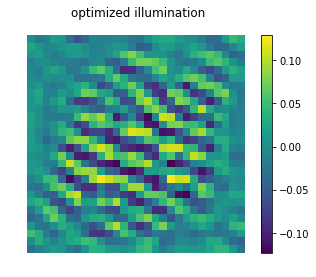

In [6]:
aper = sess.run(input_illumination_phase)
plt.figure()
plt.imshow(aper)
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized illumination")
plt.show()

### Part 1D

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib notebook

# load MNIST dataset:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# verify that the shapes are correct:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# cast as a float32:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

wavelength = .5
def convert_MNIST(X):
    # your code here
    X = X/255.0
    X_phase = X
    optical_thickness = wavelength
    X = np.exp(1j * X *optical_thickness/wavelength) #complex exponential represents phase delay
    return X

def tf_fftshift2(A):
    # 2D fftshift
    # apply fftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2] + 1
    s2 = s[-1] + 1
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def tf_ifftshift2(A):
    # 2D ifftshift
    # apply ifftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2]
    s2 = s[-1]
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def CNN2(net, numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net 

X_train = convert_MNIST(X_train)
X_test = convert_MNIST(X_test)

# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.complex64, [None, 28, 28], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

# use this flag to allow/disallow training of the input illumination; tf.Variable has an argument called "trainable":
train_illumination = False

# create the variable corresponding to the input illumination phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
input_illumination_phase = tf.get_variable("illum_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.constant_initializer(np.pi/6), trainable = train_illumination)

# using that input phase, create the input field:
input_illumination = tf.exp(1j*2*np.pi/wavelength*tf.to_complex64(input_illumination_phase))

# be sure to match the shapes/dimensions to enable broadcasting:
emerging_field = tf.math.multiply(X_batch, input_illumination)
aperture_plane = tf_fftshift2(tf.fft2d(tf_ifftshift2(emerging_field)))

y_t, x_t = np.ogrid[0:28, 0:28]
initial = (x_t - 13.5)**2 + (y_t -13.5)**2 <= 8 * 8
initial = initial.reshape((28,28))

# use this flag to allow/disallow training of the aperture plane; pass this into the tf.Variable definition:
train_aperture = True

# the aperture function consists of two parts: 1) the circular aperture as in HW4, and 2) a trainable 28x28 phase array
# create a circular aperture as you did in HW4:
circ_aper = initial

# create the variable corresponding to the aperture phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
aperture_phase = tf.get_variable("aper_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.constant_initializer(0), trainable = train_aperture)

# write the full aperture function, combining the above two components:
aperture = tf.multiply(tf.to_complex64(circ_aper), tf.exp(1j*2*np.pi*tf.to_complex64(aperture_phase)))

# filter the field that you propagated:
aperture_plane_filtered = tf.multiply(aperture_plane, aperture)

# propagate the field from the aperture plane to the image plane and convert it to intensity:
image = tf.abs(tf_ifftshift2(tf.ifft2d(tf_fftshift2(aperture_plane_filtered))))

# add noise:
image += tf.random_normal(shape=(28,28), stddev = 0.05)

net_input_layer = image[..., None]  # add a channels dimension

# define your CNN here
logits = CNN2(net_input_layer)

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

prediction = tf.argmax(logits,1)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction, tf.to_int64(y_batch))))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


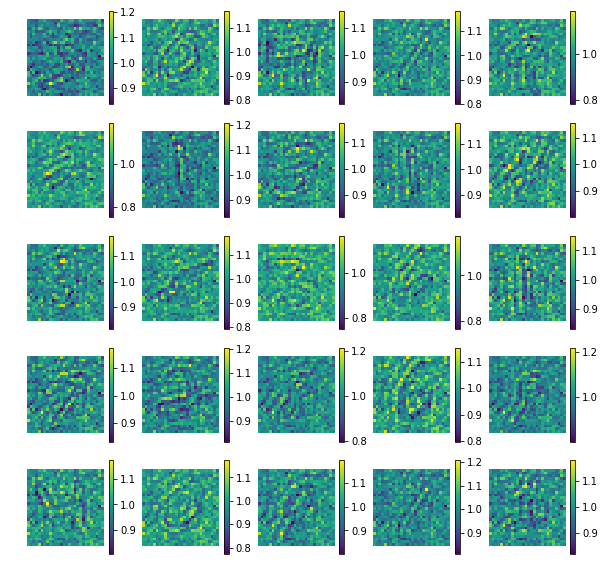

iteration 0; batch classifier loss: 2.775041
iteration 100; batch classifier loss: 1.551063
iteration 200; batch classifier loss: 0.753703
iteration 300; batch classifier loss: 0.428774
iteration 400; batch classifier loss: 0.326146
iteration 500; batch classifier loss: 0.599573
iteration 600; batch classifier loss: 0.442519
iteration 700; batch classifier loss: 0.320230
iteration 800; batch classifier loss: 0.215390
iteration 900; batch classifier loss: 0.201571
iteration 1000; batch classifier loss: 0.161585
iteration 1100; batch classifier loss: 0.466904
iteration 1200; batch classifier loss: 0.102781
iteration 1300; batch classifier loss: 0.072046
iteration 1400; batch classifier loss: 0.369951
iteration 1500; batch classifier loss: 0.125234
iteration 1600; batch classifier loss: 0.260331
iteration 1700; batch classifier loss: 0.173424
iteration 1800; batch classifier loss: 0.271229
iteration 1900; batch classifier loss: 0.458785
iteration 2000; batch classifier loss: 0.211152
iter

In [2]:
# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})
# train loop:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i])
        plt.colorbar()
        plt.axis('off')
    plt.show()
plot_examples(image.eval())

for i in range(20001):
    _, tloss = sess.run([train_op, loss])
    if i%100==0:
        print("iteration %d; batch classifier loss: %f" % (i,tloss))

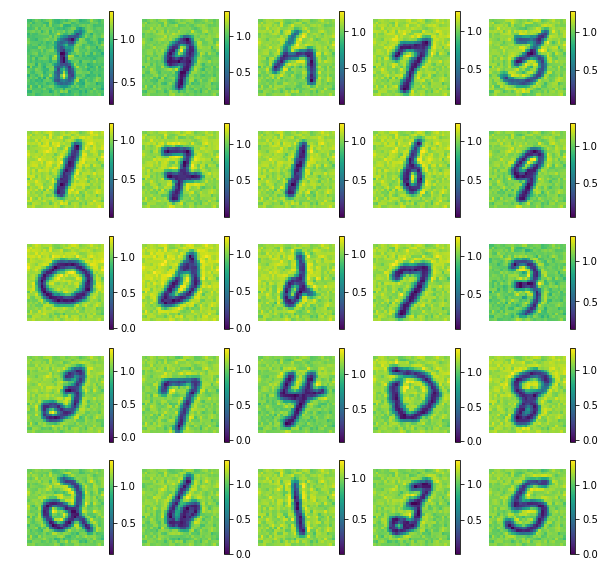

In [3]:
plot_examples(image.eval())

In [4]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test, y_train_or_test: y_test})
acc = []
# pass through test set:
for i in trange(len(X_test)//batch_size+1):
    batchacc = sess.run(accuracy)
    acc.append(batchacc)
print("accuracy:", np.mean(acc))

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 283.76it/s]


accuracy: 0.98352635


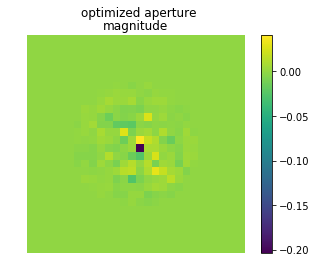

In [5]:
aper = sess.run(aperture_phase)
plt.figure()
plt.imshow(aper)
plt.title("magnitude")
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized aperture")
plt.show()

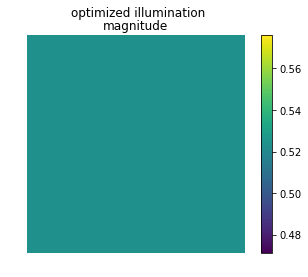

In [6]:
aper = sess.run(input_illumination_phase)
plt.figure()
plt.imshow(aper)
plt.title("magnitude")
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized illumination")
plt.show()

#### Part 2A

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib notebook

# load MNIST dataset:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# verify that the shapes are correct:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# cast as a float32:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

wavelength = .5
def convert_MNIST(X):
    # your code here
    X = X/255.0
    X_phase = X
    optical_thickness = wavelength
    X = np.exp(1j * X *optical_thickness/wavelength) #complex exponential represents phase delay
    return X

def tf_fftshift2(A):
    # 2D fftshift
    # apply fftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2] + 1
    s2 = s[-1] + 1
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def tf_ifftshift2(A):
    # 2D ifftshift
    # apply ifftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2]
    s2 = s[-1]
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def CNN2(net, numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net 

X_train = convert_MNIST(X_train)
X_test = convert_MNIST(X_test)

# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.complex64, [None, 28, 28], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

# use this flag to allow/disallow training of the input illumination; tf.Variable has an argument called "trainable":
train_illumination = False

# create the variable corresponding to the input illumination phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
input_illumination_phase = tf.get_variable("illum_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.initializers.truncated_normal(), trainable = train_illumination)

# using that input phase, create the input field:
input_illumination = tf.exp(1j*2*np.pi/wavelength*tf.to_complex64(input_illumination_phase))

# be sure to match the shapes/dimensions to enable broadcasting:
emerging_field = tf.math.multiply(X_batch, input_illumination)
aperture_plane = tf_fftshift2(tf.fft2d(tf_ifftshift2(emerging_field)))

y_t, x_t = np.ogrid[0:28, 0:28]
initial = (x_t - 13.5)**2 + (y_t -13.5)**2 <= 8 * 8
initial = initial.reshape((28,28))

# use this flag to allow/disallow training of the aperture plane; pass this into the tf.Variable definition:
train_aperture = False

# the aperture function consists of two parts: 1) the circular aperture as in HW4, and 2) a trainable 28x28 phase array
# create a circular aperture as you did in HW4:
circ_aper = initial

# create the variable corresponding to the aperture phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
aperture_phase = tf.get_variable("aper_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.initializers.truncated_normal(), trainable = train_aperture)

# write the full aperture function, combining the above two components:
aperture = tf.multiply(tf.to_complex64(circ_aper), tf.exp(1j*2*np.pi*tf.to_complex64(aperture_phase)))

# filter the field that you propagated:
aperture_plane_filtered = tf.multiply(aperture_plane, aperture)

# propagate the field from the aperture plane to the image plane and convert it to intensity:
image = tf.abs(tf_ifftshift2(tf.ifft2d(tf_fftshift2(aperture_plane_filtered))))

# add noise:
image += tf.random_normal(shape=(28,28), stddev = 0.05)

net_input_layer = image[..., None]  # add a channels dimension

# define your CNN here
logits = CNN2(net_input_layer)

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

prediction = tf.argmax(logits,1)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction, tf.to_int64(y_batch))))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


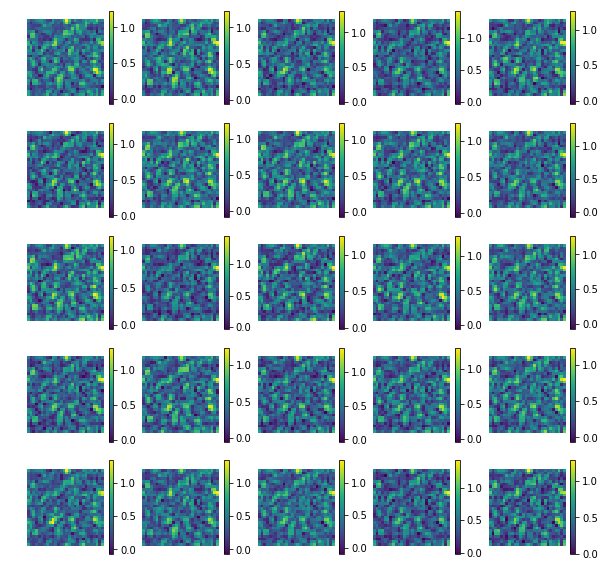

iteration 0; batch classifier loss: 4.300168
iteration 100; batch classifier loss: 1.450894
iteration 200; batch classifier loss: 1.133937
iteration 300; batch classifier loss: 0.855167
iteration 400; batch classifier loss: 0.635706
iteration 500; batch classifier loss: 0.917452
iteration 600; batch classifier loss: 0.650661
iteration 700; batch classifier loss: 0.453530
iteration 800; batch classifier loss: 0.524309
iteration 900; batch classifier loss: 0.903455
iteration 1000; batch classifier loss: 0.604321
iteration 1100; batch classifier loss: 0.609178
iteration 1200; batch classifier loss: 0.416364
iteration 1300; batch classifier loss: 0.365500
iteration 1400; batch classifier loss: 0.564330
iteration 1500; batch classifier loss: 0.232815
iteration 1600; batch classifier loss: 0.758960
iteration 1700; batch classifier loss: 0.388499
iteration 1800; batch classifier loss: 0.645833
iteration 1900; batch classifier loss: 0.625781
iteration 2000; batch classifier loss: 0.494087
iter

iteration 16900; batch classifier loss: 0.333069
iteration 17000; batch classifier loss: 0.391113
iteration 17100; batch classifier loss: 0.290041
iteration 17200; batch classifier loss: 0.138245
iteration 17300; batch classifier loss: 0.197675
iteration 17400; batch classifier loss: 0.103204
iteration 17500; batch classifier loss: 0.376997
iteration 17600; batch classifier loss: 0.045432
iteration 17700; batch classifier loss: 0.358778
iteration 17800; batch classifier loss: 0.175148
iteration 17900; batch classifier loss: 0.149143
iteration 18000; batch classifier loss: 0.415019
iteration 18100; batch classifier loss: 0.105626
iteration 18200; batch classifier loss: 0.432729
iteration 18300; batch classifier loss: 0.124089
iteration 18400; batch classifier loss: 0.091748
iteration 18500; batch classifier loss: 0.196351
iteration 18600; batch classifier loss: 0.142092
iteration 18700; batch classifier loss: 0.069313
iteration 18800; batch classifier loss: 0.101197
iteration 18900; bat

In [2]:
# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})
# train loop:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i])
        plt.colorbar()
        plt.axis('off')
    plt.show()
plot_examples(image.eval())

for i in range(20001):
    _, tloss = sess.run([train_op, loss])
    if i%100==0:
        print("iteration %d; batch classifier loss: %f" % (i,tloss))

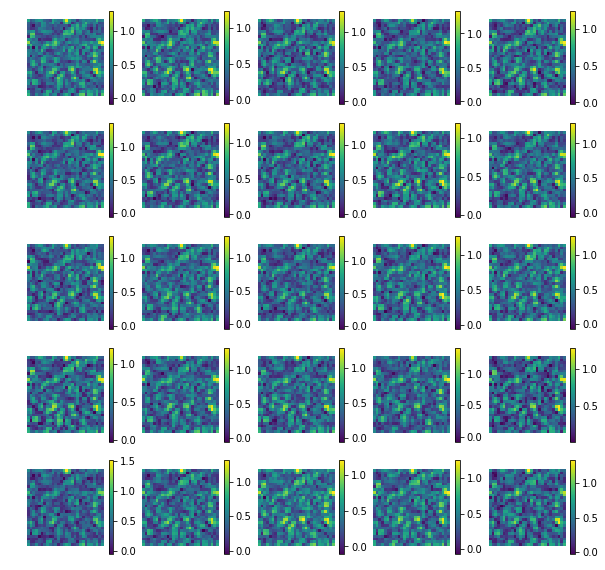

In [3]:
plot_examples(image.eval())

In [4]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test, y_train_or_test: y_test})
acc = []
# pass through test set:
for i in trange(len(X_test)//batch_size+1):
    batchacc = sess.run(accuracy)
    acc.append(batchacc)
print("accuracy:", np.mean(acc))

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 291.01it/s]


accuracy: 0.93340653


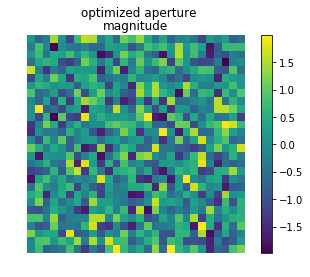

In [5]:
aper = sess.run(aperture_phase)
plt.figure()
plt.imshow(aper)
plt.title("magnitude")
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized aperture")
plt.show()

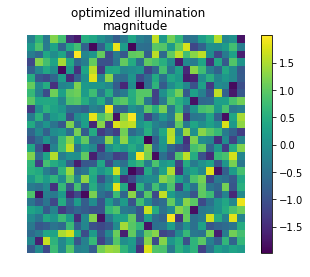

In [6]:
aper = sess.run(input_illumination_phase)
plt.figure()
plt.imshow(aper)
plt.title("magnitude")
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized illumination")
plt.show()

#### Part 2B-1

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib notebook

# load MNIST dataset:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# verify that the shapes are correct:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# cast as a float32:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

wavelength = .5
def convert_MNIST(X):
    # your code here
    X = X/255.0
    X_phase = X
    optical_thickness = wavelength
    X = np.exp(1j * X *optical_thickness/wavelength) #complex exponential represents phase delay
    return X

def tf_fftshift2(A):
    # 2D fftshift
    # apply fftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2] + 1
    s2 = s[-1] + 1
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def tf_ifftshift2(A):
    # 2D ifftshift
    # apply ifftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2]
    s2 = s[-1]
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def CNN2(net, numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net 

X_train = convert_MNIST(X_train)
X_test = convert_MNIST(X_test)

# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.complex64, [None, 28, 28], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

# use this flag to allow/disallow training of the input illumination; tf.Variable has an argument called "trainable":
train_illumination = False

# create the variable corresponding to the input illumination phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
input_illumination_phase = tf.get_variable("illum_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.constant_initializer(np.pi/6), trainable = train_illumination)

# using that input phase, create the input field:
input_illumination = tf.exp(1j*2*np.pi/wavelength*tf.to_complex64(input_illumination_phase))

# be sure to match the shapes/dimensions to enable broadcasting:
emerging_field = tf.math.multiply(X_batch, input_illumination)
aperture_plane = tf_fftshift2(tf.fft2d(tf_ifftshift2(emerging_field)))

y_t, x_t = np.ogrid[0:28, 0:28]
initial = (x_t - 13.5)**2 + (y_t -13.5)**2 <= 16 * 16
initial = initial.reshape((28,28))

# use this flag to allow/disallow training of the aperture plane; pass this into the tf.Variable definition:
train_aperture = False

# the aperture function consists of two parts: 1) the circular aperture as in HW4, and 2) a trainable 28x28 phase array
# create a circular aperture as you did in HW4:
circ_aper = initial

# create the variable corresponding to the aperture phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
aperture_phase = tf.get_variable("aper_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.constant_initializer(0), trainable = train_aperture)

# write the full aperture function, combining the above two components:
aperture = tf.multiply(tf.to_complex64(circ_aper), tf.exp(1j*2*np.pi*tf.to_complex64(aperture_phase)))

# filter the field that you propagated:
aperture_plane_filtered = tf.multiply(aperture_plane, aperture)

# propagate the field from the aperture plane to the image plane and convert it to intensity:
image = tf.abs(tf_ifftshift2(tf.ifft2d(tf_fftshift2(aperture_plane_filtered))))

# add noise:
image += tf.random_normal(shape=(28,28), stddev = 0.05)

net_input_layer = image[..., None]  # add a channels dimension

# define your CNN here
logits = CNN2(net_input_layer)

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

prediction = tf.argmax(logits,1)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction, tf.to_int64(y_batch))))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


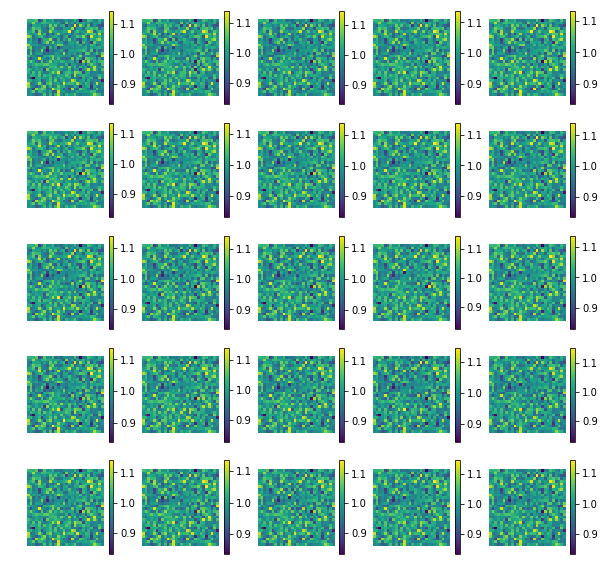

iteration 0; batch classifier loss: 3.306226
iteration 100; batch classifier loss: 2.317022
iteration 200; batch classifier loss: 2.393589
iteration 300; batch classifier loss: 2.292139
iteration 400; batch classifier loss: 2.329929
iteration 500; batch classifier loss: 2.310118
iteration 600; batch classifier loss: 2.296448
iteration 700; batch classifier loss: 2.318182
iteration 800; batch classifier loss: 2.330900
iteration 900; batch classifier loss: 2.363858
iteration 1000; batch classifier loss: 2.303620
iteration 1100; batch classifier loss: 2.453165
iteration 1200; batch classifier loss: 2.348040
iteration 1300; batch classifier loss: 2.276243
iteration 1400; batch classifier loss: 2.322186
iteration 1500; batch classifier loss: 2.331751
iteration 1600; batch classifier loss: 2.372874
iteration 1700; batch classifier loss: 2.353606
iteration 1800; batch classifier loss: 2.269653
iteration 1900; batch classifier loss: 2.441524
iteration 2000; batch classifier loss: 2.344627
iter

iteration 16900; batch classifier loss: 2.392091
iteration 17000; batch classifier loss: 2.328002
iteration 17100; batch classifier loss: 2.322281
iteration 17200; batch classifier loss: 2.336174
iteration 17300; batch classifier loss: 2.308285
iteration 17400; batch classifier loss: 2.319821
iteration 17500; batch classifier loss: 2.313208
iteration 17600; batch classifier loss: 2.318937
iteration 17700; batch classifier loss: 2.342341
iteration 17800; batch classifier loss: 2.403820
iteration 17900; batch classifier loss: 2.328380
iteration 18000; batch classifier loss: 2.304986
iteration 18100; batch classifier loss: 2.326478
iteration 18200; batch classifier loss: 2.316272
iteration 18300; batch classifier loss: 2.312020
iteration 18400; batch classifier loss: 2.335576
iteration 18500; batch classifier loss: 2.345346
iteration 18600; batch classifier loss: 2.374930
iteration 18700; batch classifier loss: 2.352178
iteration 18800; batch classifier loss: 2.298348
iteration 18900; bat

In [2]:
# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})
# train loop:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i])
        plt.colorbar()
        plt.axis('off')
    plt.show()
plot_examples(image.eval())

for i in range(20001):
    _, tloss = sess.run([train_op, loss])
    if i%100==0:
        print("iteration %d; batch classifier loss: %f" % (i,tloss))

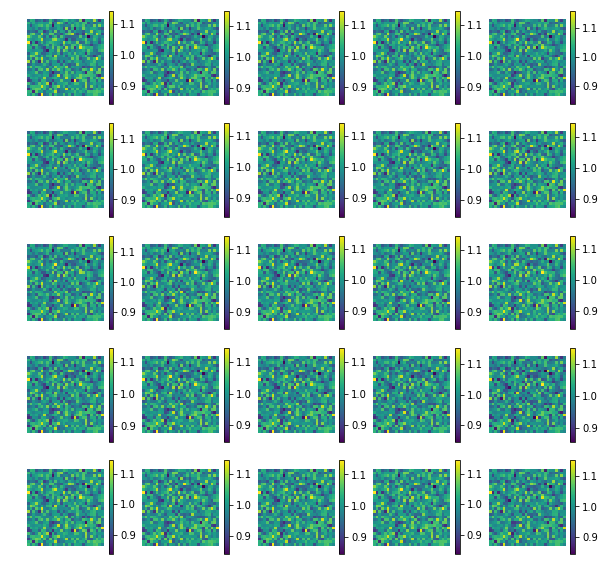

In [3]:
plot_examples(image.eval())

In [4]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test, y_train_or_test: y_test})
acc = []
# pass through test set:
for i in trange(len(X_test)//batch_size+1):
    batchacc = sess.run(accuracy)
    acc.append(batchacc)
print("accuracy:", np.mean(acc))

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 294.68it/s]


accuracy: 0.11351837


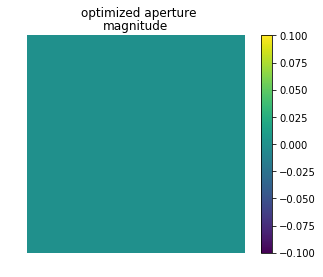

In [5]:
aper = sess.run(aperture_phase)
plt.figure()
plt.imshow(aper)
plt.title("magnitude")
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized aperture")
plt.show()

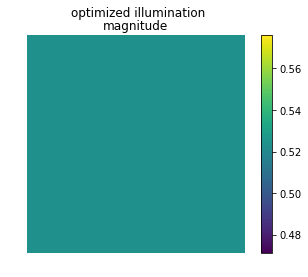

In [6]:
aper = sess.run(input_illumination_phase)
plt.figure()
plt.imshow(aper)
plt.title("magnitude")
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized illumination")
plt.show()

#### Part 2B-2


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib notebook

# load MNIST dataset:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# verify that the shapes are correct:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# cast as a float32:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

wavelength = .5
def convert_MNIST(X):
    # your code here
    X = X/255.0
    X_phase = X
    optical_thickness = wavelength
    X = np.exp(1j * X *optical_thickness/wavelength) #complex exponential represents phase delay
    return X

def tf_fftshift2(A):
    # 2D fftshift
    # apply fftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2] + 1
    s2 = s[-1] + 1
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def tf_ifftshift2(A):
    # 2D ifftshift
    # apply ifftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2]
    s2 = s[-1]
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

def CNN2(net, numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net 

X_train = convert_MNIST(X_train)
X_test = convert_MNIST(X_test)

# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.complex64, [None, 28, 28], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

# use this flag to allow/disallow training of the input illumination; tf.Variable has an argument called "trainable":
train_illumination = True

# create the variable corresponding to the input illumination phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
input_illumination_phase = tf.get_variable("illum_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.constant_initializer(np.pi/6), trainable = train_illumination)

# using that input phase, create the input field:
input_illumination = tf.exp(1j*2*np.pi/wavelength*tf.to_complex64(input_illumination_phase))

# be sure to match the shapes/dimensions to enable broadcasting:
emerging_field = tf.math.multiply(X_batch, input_illumination)
aperture_plane = tf_fftshift2(tf.fft2d(tf_ifftshift2(emerging_field)))

y_t, x_t = np.ogrid[0:28, 0:28]
initial = (x_t - 13.5)**2 + (y_t -13.5)**2 <= 4 * 4
initial = initial.reshape((28,28))

# use this flag to allow/disallow training of the aperture plane; pass this into the tf.Variable definition:
train_aperture = True

# the aperture function consists of two parts: 1) the circular aperture as in HW4, and 2) a trainable 28x28 phase array
# create a circular aperture as you did in HW4:
circ_aper = initial

# create the variable corresponding to the aperture phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
aperture_phase = tf.get_variable("aper_phase", dtype = tf.float32, shape = [28,28], 
                                           initializer=tf.constant_initializer(0), trainable = train_aperture)

# write the full aperture function, combining the above two components:
aperture = tf.multiply(tf.to_complex64(circ_aper), tf.exp(1j*2*np.pi*tf.to_complex64(aperture_phase)))

# filter the field that you propagated:
aperture_plane_filtered = tf.multiply(aperture_plane, aperture)

# propagate the field from the aperture plane to the image plane and convert it to intensity:
image = tf.abs(tf_ifftshift2(tf.ifft2d(tf_fftshift2(aperture_plane_filtered))))

# add noise:
image += tf.random_normal(shape=(28,28), stddev = 0.05)

net_input_layer = image[..., None]  # add a channels dimension

# define your CNN here
logits = CNN2(net_input_layer)

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

prediction = tf.argmax(logits,1)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction, tf.to_int64(y_batch))))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


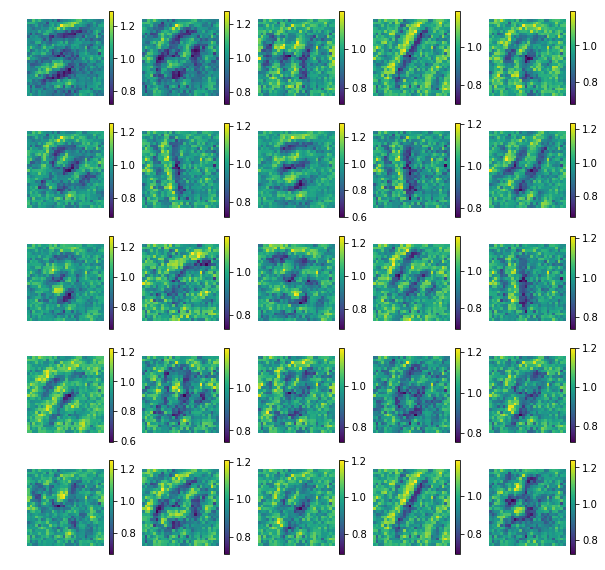

iteration 0; batch classifier loss: 3.462867
iteration 100; batch classifier loss: 1.191589
iteration 200; batch classifier loss: 0.643761
iteration 300; batch classifier loss: 0.306287
iteration 400; batch classifier loss: 0.371504
iteration 500; batch classifier loss: 0.699646
iteration 600; batch classifier loss: 0.391142
iteration 700; batch classifier loss: 0.475613
iteration 800; batch classifier loss: 0.207646
iteration 900; batch classifier loss: 0.202541
iteration 1000; batch classifier loss: 0.287899
iteration 1100; batch classifier loss: 0.553942
iteration 1200; batch classifier loss: 0.128590
iteration 1300; batch classifier loss: 0.095047
iteration 1400; batch classifier loss: 0.279737
iteration 1500; batch classifier loss: 0.117066
iteration 1600; batch classifier loss: 0.219677
iteration 1700; batch classifier loss: 0.152861
iteration 1800; batch classifier loss: 0.310952
iteration 1900; batch classifier loss: 0.468401
iteration 2000; batch classifier loss: 0.159625
iter

iteration 16900; batch classifier loss: 0.094328
iteration 17000; batch classifier loss: 0.027349
iteration 17100; batch classifier loss: 0.092946
iteration 17200; batch classifier loss: 0.049369
iteration 17300; batch classifier loss: 0.039069
iteration 17400; batch classifier loss: 0.106440
iteration 17500; batch classifier loss: 0.098672
iteration 17600; batch classifier loss: 0.011315
iteration 17700; batch classifier loss: 0.115770
iteration 17800; batch classifier loss: 0.020265
iteration 17900; batch classifier loss: 0.024871
iteration 18000; batch classifier loss: 0.122073
iteration 18100; batch classifier loss: 0.029632
iteration 18200; batch classifier loss: 0.159983
iteration 18300; batch classifier loss: 0.065805
iteration 18400; batch classifier loss: 0.032499
iteration 18500; batch classifier loss: 0.068133
iteration 18600; batch classifier loss: 0.079344
iteration 18700; batch classifier loss: 0.005238
iteration 18800; batch classifier loss: 0.014640
iteration 18900; bat

In [2]:
# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})
# train loop:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i])
        plt.colorbar()
        plt.axis('off')
    plt.show()
plot_examples(image.eval())

for i in range(20001):
    _, tloss = sess.run([train_op, loss])
    if i%100==0:
        print("iteration %d; batch classifier loss: %f" % (i,tloss))

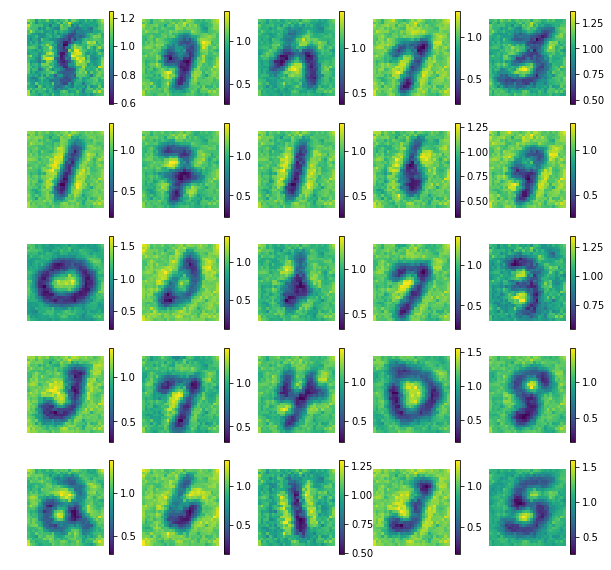

In [3]:
plot_examples(image.eval())

In [4]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test, y_train_or_test: y_test})
acc = []
# pass through test set:
for i in trange(len(X_test)//batch_size+1):
    batchacc = sess.run(accuracy)
    acc.append(batchacc)
print("accuracy:", np.mean(acc))

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 287.66it/s]


accuracy: 0.97723645


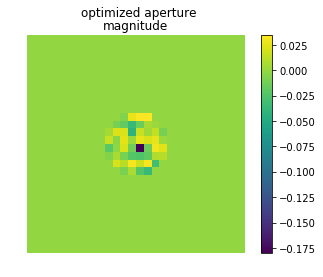

In [5]:
aper = sess.run(aperture_phase)
plt.figure()
plt.imshow(aper)
plt.title("magnitude")
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized aperture")
plt.show()

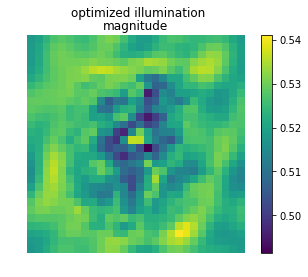

In [6]:
aper = sess.run(input_illumination_phase)
plt.figure()
plt.imshow(aper)
plt.title("magnitude")
plt.colorbar()
plt.axis('off')
plt.suptitle("optimized illumination")
plt.show()